In [ ]:
# Test, ob GPU vorhanden ist

import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

In [ ]:
# GPUs anzeigen lassen

if cuda_available:
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. Running on CPU.")


In [ ]:
# Meeting mit Benjamin, 25.03.
# Output als tatsächliche Preise schreiben
# So das Programm schreiben, dass man die Modelle austauschen kann (RNN; LSTM; GRU)

# Weights speichern und danach wiederverwenden
# Pytorch Lightning verwenden
# Preprocessing speziell für Time Series (Differencing und Log) -> Data normalization
# Welche zusätzliche Daten (sin, cos encoding vom Tag, Woche, Monat) - Relevant für Seasonalität
# Sin cos encoding
# Mögliche Modelle: State Space Models (Mamba)
# Vor 2022 als training set benutzen und 2022 (neues Regime) als validation um Model zu testen

### wandb login

In [ ]:
import wandb
wandb.login()

### Evaluate model with tensorboard
After running the script, open terminal, cd to project directory and \
`tensorboard --logdir=runs` \
\
In your browser, open \
[http://localhost:6006/](http://localhost:6006/)  
<br>

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


[*********************100%%**********************]  1 of 1 completed


Epoch 0 | Training Loss: 0.28936237628598366 | Validation Loss: 3.7693690856297812
Epoch 10 | Training Loss: 0.005585421569170042 | Validation Loss: 0.368190615127484
Epoch 20 | Training Loss: 0.0016168585146563903 | Validation Loss: 0.2369201648980379
Epoch 30 | Training Loss: 0.0009079978841934159 | Validation Loss: 0.21721622968713442
Epoch 40 | Training Loss: 0.0007757284476307783 | Validation Loss: 0.18500835665812096
Epoch 50 | Training Loss: 0.0005756778987233702 | Validation Loss: 0.13731718653192124
Epoch 60 | Training Loss: 0.0011738027468103003 | Validation Loss: 0.10421333539610107
Epoch 70 | Training Loss: 0.0015452090429638095 | Validation Loss: 0.07045841620614131
Epoch 80 | Training Loss: 0.0016394575571515209 | Validation Loss: 0.024634495959617198
Epoch 90 | Training Loss: 0.004878839312520237 | Validation Loss: 0.007228605371589462
Epoch 100 | Training Loss: 0.0013832345484085333 | Validation Loss: 0.0077578120593292015
Epoch 110 | Training Loss: 0.000442127926210863

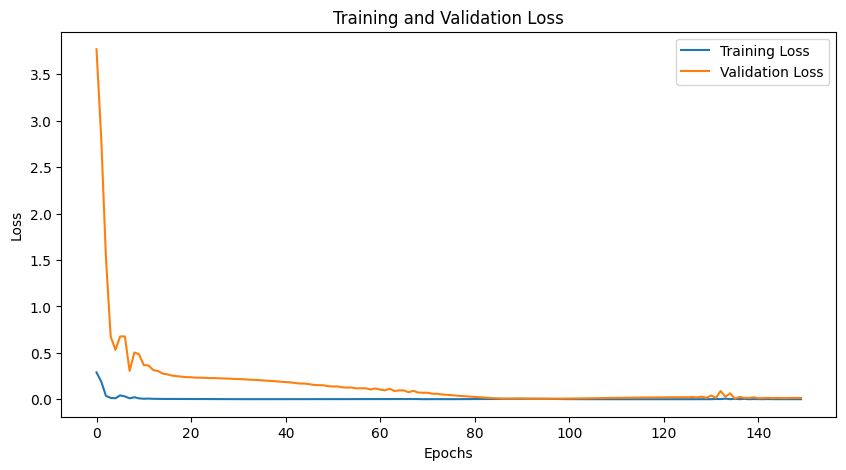

MSE: 0.008400872474393363
RMSE: 0.0916562735135646
MAE: 0.07456895692662878
R-squared: 0.9446251186502871
MAPE: 0.04717368567424145


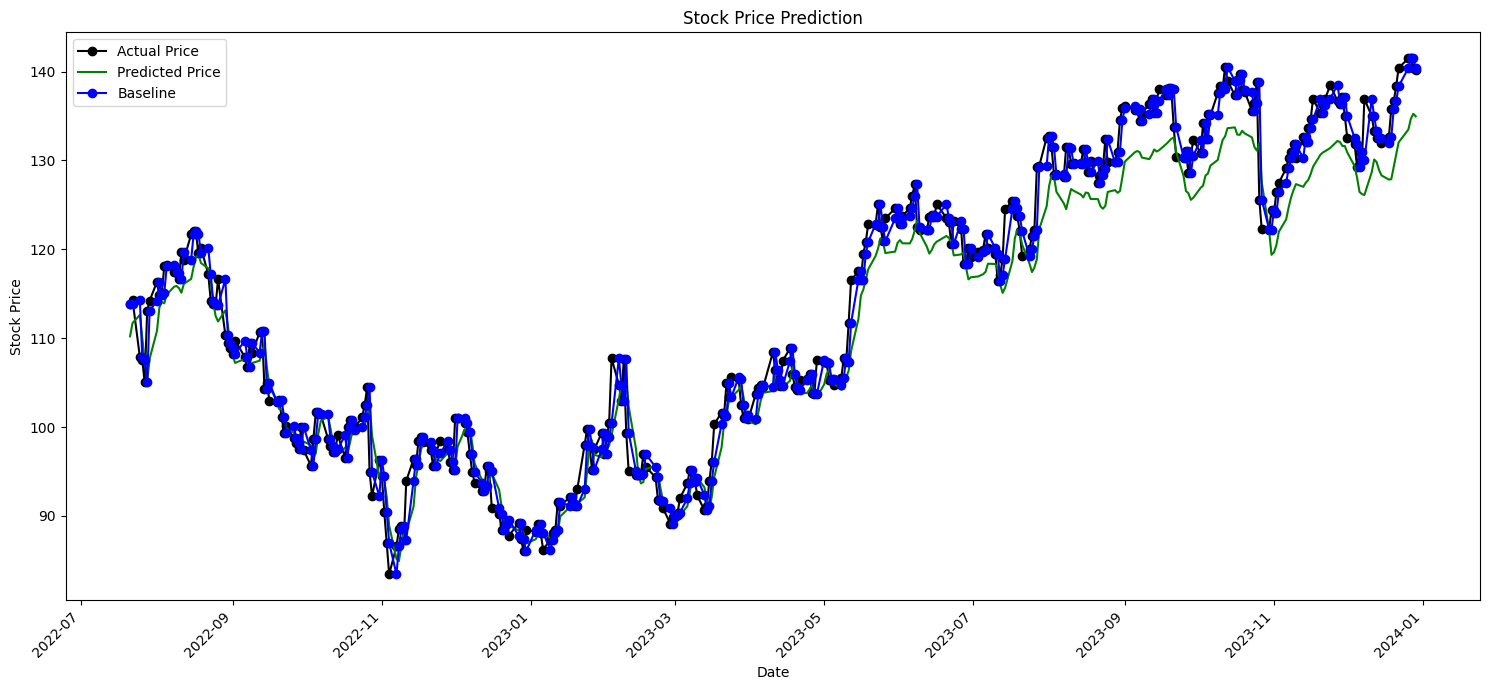

training_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,0.00064
validation_loss,0.01435


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
from configuration import stock_ticker, company_name, architecture, num_units, num_layers, dropout_prob, model, seq_length, start_date, end_date, num_epochs, learning_rate
import wandb
import os
import tempfile
import io

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seqs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        training_loss = np.mean(train_losses)
        training_losses.append(training_loss)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for seqs, labels in val_loader:
                seqs, labels = seqs.to(device), labels.to(device)
                y_pred = model(seqs)
                val_losses.append(criterion(y_pred, labels).item())
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)

        wandb.log({"training_loss": training_loss, "validation_loss": validation_loss})

        """
        if writer:
            writer.add_scalar('Loss/train', training_loss, epoch)
            writer.add_scalar('Loss/validation', validation_loss, epoch)
        """

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Training Loss: {training_loss} | Validation Loss: {validation_loss}')
    
    return training_losses, validation_losses

def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for seqs, labels in test_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            output = model(seqs)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())
    return np.array(predictions), np.array(actuals)

def inverse_transform_scaler(values, scaler):
    values_reshaped = values.reshape(-1, 1)
    return scaler.inverse_transform(values_reshaped)

"""
def plot_predictions_with_dates(predictions, actuals, dates, scaler):
    predictions_original_scale = inverse_transform_scaler(np.array(predictions), scaler)
    actuals_original_scale = inverse_transform_scaler(np.array(actuals), scaler)
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates, actuals_original_scale, label='Actual Price', color='blue', marker='o')
    plt.plot(dates, predictions_original_scale, label='Predicted Price', color='red', linestyle='--')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    wandb.log({"label": plt})
    plt.show()
"""

def plot_predictions_with_dates(predictions, actuals, dates, scaler):
    predictions_original_scale = list(inverse_transform_scaler(np.array(predictions), scaler))
    actuals_original_scale = list(inverse_transform_scaler(np.array(actuals), scaler))
    baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(dates, actuals_original_scale, label='Actual Price', color='black', linestyle='-', marker='o')
    ax.plot(dates, predictions_original_scale, label='Predicted Price', color='green', linestyle='-')
    ax.plot(dates, baseline_original_scale, label='Baseline', color='blue', linestyle='-', marker='o')

    ax.set_title('Stock Price Prediction')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')
    ax.legend()
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.plot()
    plt.show()
    
    filename = "plot.png"
    fig.savefig(filename)
    wandb.log({"Stock Price Prediction": wandb.Image(filename)})
    os.remove(filename)
    plt.close(fig)


wandb.init(
    project="RNN_single_step_forecasts",
    config={
        "dataset": f"{company_name} closing prices",
        "architecture": architecture,
        "num_units": num_units,
        "num_layers": num_layers,
        "dropout": dropout_prob,
        "seq_length": seq_length,
        "start_date": start_date,
        "end_date": end_date,
        "epochs": num_epochs,
        "learning_rate": learning_rate
    }
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# writer = SummaryWriter('runs/rnn_model')

# Obtaining data and preprocessing
stock_df = yf.download(stock_ticker, start=start_date, end=end_date)

split_idx = int(len(stock_df) * 0.8) + seq_length
train_df = stock_df.iloc[:split_idx]
temp_df = stock_df.iloc[split_idx:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train_df[['Close']].values.reshape(-1, 1))
X_train, y_train = create_sequences(train_normalized, seq_length)

temp_normalized = scaler.transform(temp_df[['Close']].values.reshape(-1, 1))
X_temp, y_temp = create_sequences(temp_normalized, seq_length)

split_idx_temp = len(y_temp) // 2
X_val, X_test = X_temp[:split_idx_temp], X_temp[split_idx_temp:]
y_val, y_test = y_temp[:split_idx_temp], y_temp[split_idx_temp:]

train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)

# Add model graph to tensorboard
# sample_input_tensor = torch.randn((1, seq_length, 1)).to(device)
# writer.add_graph(model, sample_input_tensor)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and validation
training_losses, validation_losses = train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
plot_losses(training_losses, validation_losses)

# Evaluation of the model on the test set
predictions, actuals = evaluate_model(model, test_loader)
dates = list(stock_df.index[(-len(predictions)):])
dates = sorted(dates)

print(f'MSE: {mean_squared_error(actuals, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(actuals, predictions))}')
print(f'MAE: {mean_absolute_error(actuals, predictions)}')
print(f'R-squared: {r2_score(actuals, predictions)}')
print(f'MAPE: {np.mean(np.abs(actuals - predictions) / actuals)}')

plot_predictions_with_dates(predictions, actuals, dates, scaler)
wandb.finish()
# writer.close()


In [ ]:
print(baseline[:20])

In [ ]:
stock_df.tail()

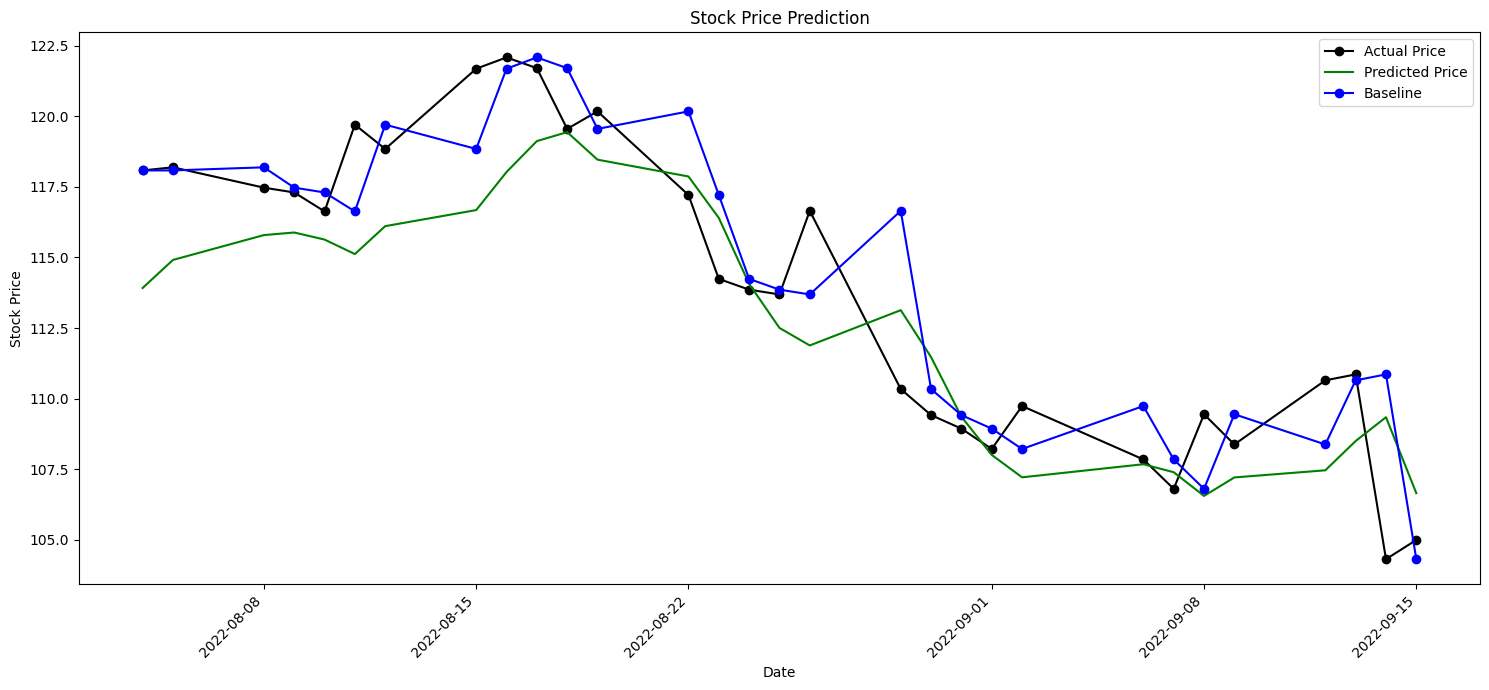

Error: You must call wandb.init() before wandb.log()

In [2]:
plot_predictions_with_dates(predictions[10:40], actuals[10:40], dates[10:40], scaler)

In [ ]:
dates = stock_df.index[-len(predictions):]
print(dates)

In [ ]:
# Diagnostic plot without scaling
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(dates[:10], actuals[:10], label='Actual Price', color='black', linestyle='-', marker='o')
ax.plot(dates[1:10], actuals[:9], label='Baseline', color='blue', linestyle='-', marker='o')
# Then set date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Ensure a tick every day if necessary
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate date labels for clarity
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Ensure that Matplotlib uses the date formatting for the plot layout
fig.autofmt_xdate()  # Auto formats the x-axis to fit the date labels
ax.set_title('Diagnostic Stock Price Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
print(actuals[1:10])

In [ ]:
print(actuals[:10])

In [ ]:
test = list(actuals.copy())

forecast_test = [test[0]] + test[:-1]


print(test[:10])
print(forecast_test[:10])

In [ ]:
print(type(dates))

In [ ]:
predictions_original_scale = list(inverse_transform_scaler(np.array(predictions), scaler))
actuals_original_scale = list(inverse_transform_scaler(np.array(actuals), scaler))
baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]

In [ ]:
print(actuals_original_scale[:10])
print(baseline_original_scale[:10])

In [ ]:
plt.plot(actuals_original_scale[:10])  
plt.plot(baseline_original_scale[:10]) 